---
title: Introduction to Probabilistic Programming
author: Mark Fuge
date: 'December 7 2025'
format:
    html:
        code-fold: true
        code-summary: "Show Code"
---

In past chapters, we have looked at manually defining different generative models, as well as covered the fundamentals of inference algorithms (e.g., MCMC, Variational Inference). However, as models grow in complexity, or if we wish to combine elements of probabilistic models with Deep Learning, manually implementing these models and inference algorithms can become cumbersome and error-prone. *Probabilistic Programming Languages* (PPLs) were developed to help address this challenge. They work by providing high-level abstractions for defining probabilistic models as well as routines for performing inference on those models. There are [lists of PPLs available online](https://en.wikipedia.org/wiki/Probabilistic_programming), but for the purposes of this chapter, our examples will you a PyTorch-based PPL called [Pyro](https://pyro.ai/).

We will demonstrate this by considering the example of inferring unknown material properties from observed stress-strain data. First, we will define a simple linear elastic model where the stress is proportional to strain via Young's modulus (E). We will then use Pyro to infer the posterior distribution of E given some observed data. It is a bit unnecessary to use a PPL for such a simple model, but it will serve to illustrate the basic concepts of how they work. We will then move onto a more complex model involving plasticity, where the benefits of using a PPL become more apparent, and we will see how we can recover a posterior distribution over multiple material parameters.

## Learning Objectives
- Connect probabilistic programming concepts (random variables, guides, inference) to stress-strain modeling tasks.
- Wrap physics-based constitutive laws in Pyro to infer interpretable parameters with credible intervals.

In [2]:
import math
import warnings

try:
    import pyro  # type: ignore
except ModuleNotFoundError:  # pragma: no cover - convenience for Colab/VS Code
    %pip install --quiet pyro-ppl
    import pyro  # type: ignore

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, AutoNormal
from pyro.infer.mcmc import NUTS, MCMC
from pyro.optim import ClippedAdam, AdamW

warnings.filterwarnings("ignore", category=UserWarning)
torch.set_default_dtype(torch.float32)
torch.set_float32_matmul_precision("high")

SEED = 2025
pyro.set_rng_seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

sns.set_context("talk")
plt.style.use("seaborn-v0_8")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## Problem Setup: Inferring Material Properties from Stress-Strain Data

As the running example in this notebook, we will consider the problem of inferring material properties from observed stress-strain data. Specifically, we will assume that we have existing experimental data that relates stress (σ) to strain (ε) for a given material, and we wish to infer the underlying material parameters that govern this relationship. We will use a Ramberg-Osgood model to describe the stress-strain behavior of the material, which is given by the equation:
$$
\epsilon = \frac{\sigma}{E} + \alpha \left(\frac{\sigma}{\sigma_0}\right)^n
$$
where E is Young's modulus, σ₀ is the yield stress, α is a material constant, and n is the strain hardening exponent. Our goal will be to infer the parameters E, σ₀, α, and n from observed stress-strain data using probabilistic programming. For our example below, we will use generic properties of a mild steel (e.g., S235) although this could be adapted to any material or to a different constitutive model. We will also add in a bit of measurement noise (which you can also feel free to update as you see fit to see how this changes the later uncertainty bounds). Let's plot some example data:

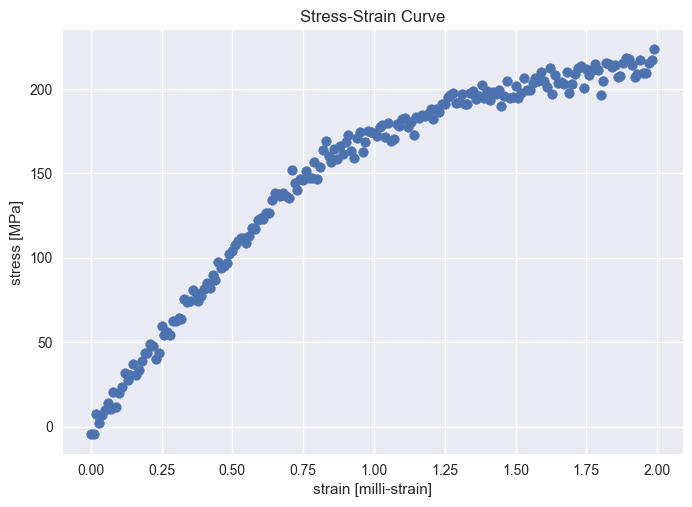

In [3]:
class RambergOsgood:
    """
    Engineering Ramberg-Osgood material model:
    
    ε = σ/E + α (σ/σ_y)^n
    
    Parameters
    ----------
    E : float
        Young's modulus.
    sigma_y : float
        Yield stress (0.2% offset)
    alpha : float
        Dimensionless constant, often 0.002.
    n : float
        Hardening exponent.
    """

    def __init__(self, E, sigma_y, alpha=0.002, n=8.0):
        self.E = E
        self.sigma_y = sigma_y
        self.alpha = alpha
        self.n = n

    def strain_from_stress(self, sigma):
        """ε(σ) from the Ramberg-Osgood equation."""
        return sigma / self.E + self.alpha * (sigma / self.sigma_y) ** self.n

    def stress_from_strain(self, eps, tol=1e-10, max_iter=50):
        """
        Numerically invert the Ramberg-Osgood relation to compute σ(ε)
        using Newton-Raphson.
        """
        # initial guess: elastic estimate
        sigma = eps * self.E

        for _ in range(max_iter):
            f = sigma / self.E + self.alpha * (sigma / self.sigma_y) ** self.n - eps
            df = (1.0 / self.E) + self.alpha * self.n * (1 / self.sigma_y) ** self.n * sigma ** (self.n - 1)

            sigma_new = sigma - f / df
            if abs(sigma_new - sigma) < tol:
                return sigma_new

            sigma = sigma_new

        raise RuntimeError("Newton iteration did not converge")

    def stress_strain_curve(self, strains):
        """Convenience function: return array of σ for σ(ε)."""
        return [self.stress_from_strain(eps) for eps in strains]


# Define a material: mild steel S235
def mild_steel_S235():
    return RambergOsgood(
        E=210e3,      # MPa
        sigma_y=235,  # MPa
        alpha=0.002,
        n=8.0
    )

mat = mild_steel_S235()
true_E = mat.E
true_sigma_y = mat.sigma_y
true_n = mat.n

# Generate the stress-strain curve
strains = [i * 0.00001 for i in range(200)]
stresses_clean = torch.Tensor(mat.stress_strain_curve(strains))
strains = torch.Tensor(strains)
noise_std = 4.0     # MPa, measurement noise
stresses = stresses_clean + torch.randn_like(stresses_clean) * noise_std

plt.figure()
plt.scatter(strains*1e3,stresses)
plt.title("Stress-Strain Curve")
plt.xlabel("strain [milli-strain]")
plt.ylabel("stress [MPa]")
plt.show()


## Bayesian Linear Regression

Let's first start with a simple model that assumes Hooke's law: $\sigma = E\varepsilon + \epsilon$. For this, we can use Linear Regression, where our goal is to compute the posterior distribution over $E$. While we could compute this in closed form for such a simple model, the goal here is to expose Pyro's main primitives: `pyro.sample` for declaring priors/likelihoods, `pyro.param` inside a guide, and stochastic variational inference (SVI) with the ELBO. Even though this toy example is small, it mirrors the workflow for more complex models that we will see later.

Since we are dealing with a linear model, let's restrict the training data to small strains where the linear approximation holds decently well: 

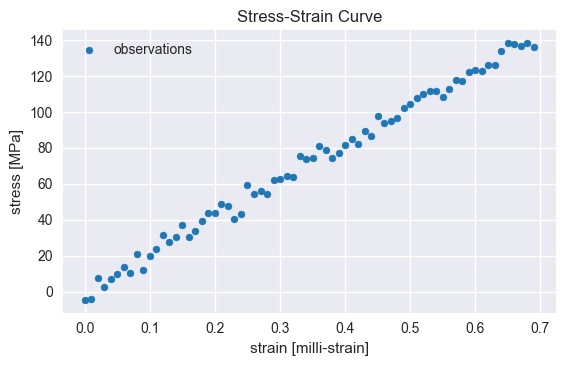

In [4]:
# Let's restrict the data to just the mostly linear portion of the model:
strain = strains[0:70]
stress = stresses[0:70]

data = {"strain": strain, "stress": stress}
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(strain.numpy() * 1e3, stress.numpy(), s=25, color="#1f77b4", label="observations")
ax.set_xlabel("strain [milli-strain]")
ax.set_ylabel("stress [MPa]")
ax.set_title("Stress-Strain Curve")
ax.legend()
plt.tight_layout()

For this Bayesian linear regression, we will:
1. Define a model with a prior on Young's modulus $E$ and a likelihood for observed stresses.
2. Define a guide (variational distribution) to approximate the posterior over $E$.
3. Set up Stochastic Variational Inference (SVI) to optimize the ELBO and learn the posterior parameters.


In [5]:
#| code-fold: false
# Define Pyro model, guide, and run SVI
pyro.clear_param_store()

def linear_model(strain: torch.Tensor, stress_obs: torch.Tensor | None = None) -> None:
    E = pyro.sample("E", dist.LogNormal(math.log(2.0e5), 0.2))
    sigma_noise = pyro.sample("sigma_noise", dist.LogNormal(math.log(5.0), 0.4))
    with pyro.plate("data", strain.shape[0]):
        mean_stress = E * strain
        pyro.sample("obs", dist.Normal(mean_stress, sigma_noise), obs=stress_obs)

# Here we define what Pyro calls a "guide" which is just
# the variational distribution over the latent variables.
def linear_guide(strain: torch.Tensor, stress_obs: torch.Tensor | None = None) -> None:
    qE_loc = pyro.param("qE_loc", torch.tensor(12.2))
    qE_scale = pyro.param("qE_scale", torch.tensor(0.1), constraint=constraints.positive)
    pyro.sample("E", dist.LogNormal(qE_loc, qE_scale))

    # Guide for the measurement noise
    q_noise_loc = pyro.param("q_noise_loc", torch.tensor(math.log(6.0)))
    q_noise_scale = pyro.param("q_noise_scale", torch.tensor(0.1), constraint=constraints.positive)
    pyro.sample("sigma_noise", dist.LogNormal(q_noise_loc, q_noise_scale))

# Now we train the model using Stochastic Variational Inference (SVI)
optimizer = AdamW({"lr": 0.01})
svi = SVI(linear_model, linear_guide, optimizer, loss=Trace_ELBO())

loss_history = []
num_steps = 3000
for step in range(num_steps):
    loss = svi.step(strain, stress)
    loss_history.append(loss / strain.shape[0])
    if (step + 1) % 500 == 0:
        print(f"Step {step + 1:04d} | per-sample ELBO: {loss_history[-1]:.2f}")

Step 0500 | per-sample ELBO: 2.82
Step 1000 | per-sample ELBO: 2.89
Step 1500 | per-sample ELBO: 2.77
Step 2000 | per-sample ELBO: 2.76
Step 2500 | per-sample ELBO: 2.78
Step 3000 | per-sample ELBO: 2.76


Now that the model has been trained, we can sample the posterior predictive of the model to sample possible values of $E$:

In [6]:
#| code-fold: false
# Posterior diagnostics and predictive uncertainty
predictive = Predictive(
    linear_model,
    guide=linear_guide,
    num_samples=1500,
    return_sites=("E", "obs"),
)
posterior_samples = predictive(strain)

And we can go ahead and plot it:

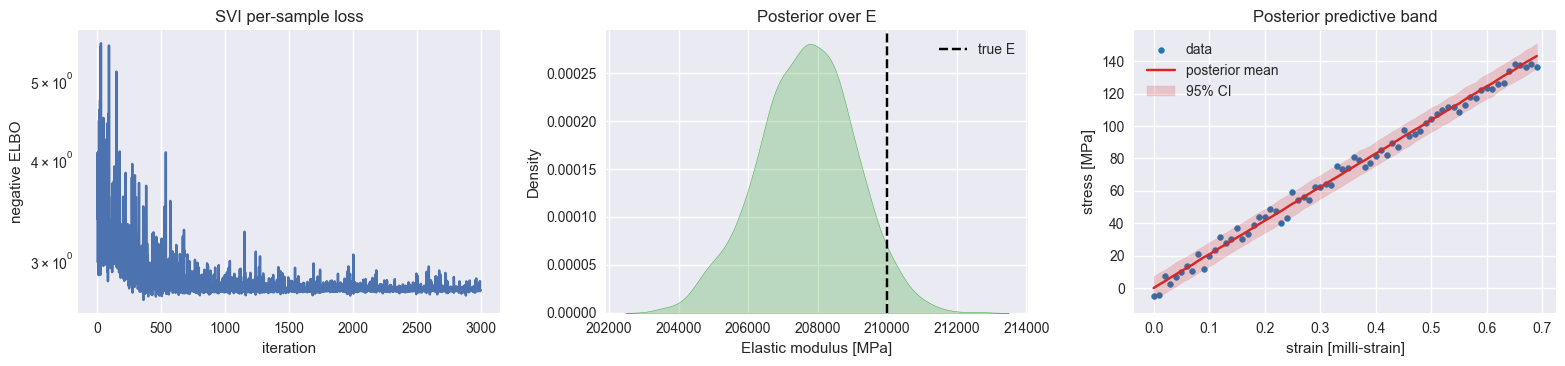

In [7]:
# ensure E_samples is 1D for seaborn/kdeplot
E_samples = posterior_samples["E"].detach().cpu().numpy().squeeze()
obs_samples = posterior_samples["obs"].detach()

mean_pred = obs_samples.mean(0)
lower_pred = obs_samples.quantile(0.025, dim=0)
upper_pred = obs_samples.quantile(0.975, dim=0)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].plot(loss_history)
axes[0].set_title("SVI per-sample loss")
axes[0].set_xlabel("iteration")
axes[0].set_ylabel("negative ELBO")
axes[0].set_yscale("log")

sns.kdeplot(x=E_samples, ax=axes[1], fill=True, color="#2ca02c")
axes[1].axvline(true_E, color="k", linestyle="--", label="true E")
axes[1].set_xlabel("Elastic modulus [MPa]")
axes[1].set_title("Posterior over E")
axes[1].legend()

axes[2].scatter(strain.numpy() * 1e3, stress.numpy(), s=18, color="#1f77b4", label="data")
axes[2].plot(strain.numpy() * 1e3, mean_pred.numpy(), color="#d62728", label="posterior mean")
axes[2].fill_between(
    strain.numpy() * 1e3,
    lower_pred.numpy(),
    upper_pred.numpy(),
    color="#d62728",
    alpha=0.2,
    label="95% CI",
)
axes[2].set_xlabel("strain [milli-strain]")
axes[2].set_ylabel("stress [MPa]")
axes[2].set_title("Posterior predictive band")
axes[2].legend()
plt.tight_layout()

We see the covergence of the SVI loss over training, as well as the posterior distribution over $E$, and also the posterior predictive distribution over stress-strain curves. The shaded regions represent credible intervals, indicating the uncertainty in our predictions due to the uncertainty in $E$. We can see from the middle plot that the estimate for $E$ is lower than the true value, which is due both to noise, as well as model misspecification (the true model is not perfectly linear). However, the true value of $E$ is on the border of the 95% credible interval.

## Bayesian Material Model Identification (Ramberg-Osgood)
For that simple example above, we didn't really need a Probabilistic Programming Langauge and could have computed the posterior in closed form. Now let's move onto a more complex material model where a closed form solution is not as straightforward, yet a PPL  has a remarkably simple implementation. Specifically, we will infer the parameters of the Ramberg-Osgood model from above, using the noisy stress-strain data:

$$
\epsilon = \frac{\sigma}{E} + \alpha \left(\frac{\sigma}{\sigma_0}\right)^n
$$

Notice below that we can directly define the model in the code itself and assign individual variables with priors using `pyro.sample`. The likelihood is also defined in a similar manner.

In [8]:
#| code-fold: false
# Pyro model and inference for Ramberg-Osgood parameters
pyro.clear_param_store()

def ramberg_osgood_model(stress: torch.Tensor, strains: torch.Tensor | None = None) -> None:
    """
    Probabilistic model for Ramberg-Osgood material parameter inference.
    
    We infer E (Young's modulus), sigma_y (yield stress), and n (hardening exponent)
    from observed strain-stress pairs.
    """
    # Priors for material parameters
    # Note how we directly assign the priors in the code
    E = pyro.sample("E", dist.LogNormal(math.log(2.1e5), 0.2))
    sigma_y = pyro.sample("sigma_y", dist.LogNormal(math.log(235.0), 0.25))
    n = pyro.sample("n", dist.LogNormal(math.log(8.0), 0.3))
    
    # Prior for measurement noise
    sigma_noise = pyro.sample("sigma_noise", dist.LogNormal(math.log(2e-4), 0.3))
    
    # Forward model: compute predicted strain from stress using Ramberg-Osgood
    # ε = σ/E + α*(σ/σ_y)^n
    alpha = 0.002  # Fixed material constant
    
    with pyro.plate("data", stress.shape[0]):
        # Add small epsilon to avoid division by zero issues and clamp the stress ratio
        eps = 1e-10
        stress_ratio = torch.clamp(stress / (sigma_y + eps), min=eps, max=1e3)
        strain_pred = stress / (E + eps) + alpha * torch.pow(stress_ratio, n)
        
        # Likelihood: observed strain given predicted strain and noise
        pyro.sample("obs", dist.Normal(strain_pred, sigma_noise), obs=strains)

# Use AutoNormal guide for automatic variational inference
# This uses a Normal distribution with a diagonal covariance matrix as the 
# Variational Distribution
#guide_ro = AutoNormal(ramberg_osgood_model)

# Alternatively, you can use a distribution with a full covariance:
guide_ro = AutoMultivariateNormal(ramberg_osgood_model)

# Set up SVI with optimizer
optimizer = ClippedAdam({"lr": 0.005, "clip_norm": 5.0})
svi = SVI(ramberg_osgood_model, guide_ro, optimizer, loss=Trace_ELBO())

# Run inference
ro_losses = []
num_steps = 10000
print("Running Ramberg-Osgood parameter inference...")
for step in range(num_steps):
    loss = svi.step(stresses, strains)
    ro_losses.append(loss / stresses.shape[0]+8)
    if (step + 1) % 800 == 0:
        print(f"Step {step + 1:04d} | per-sample loss: {ro_losses[-1]:.6f}")

print(f"\nFinal loss: {ro_losses[-1]:.6f}")

Running Ramberg-Osgood parameter inference...
Step 0800 | per-sample loss: 0.103314
Step 1600 | per-sample loss: 0.165335
Step 2400 | per-sample loss: 0.097428
Step 3200 | per-sample loss: 0.091438
Step 4000 | per-sample loss: 0.098814
Step 4800 | per-sample loss: 0.102443
Step 5600 | per-sample loss: 0.081144
Step 6400 | per-sample loss: 0.082515
Step 7200 | per-sample loss: 0.082739
Step 8000 | per-sample loss: 0.082601
Step 8800 | per-sample loss: 0.087190
Step 9600 | per-sample loss: 0.087617

Final loss: 0.100413



POSTERIOR SUMMARY STATISTICS
Parameter          | True Value | Posterior Mean | 95% CI
------------------------------------------------------------
E (MPa)           |   210000.0 |       221922.6 | [206535.0, 237921.2]
σ_y (MPa)         |      235.0 |          246.1 | [241.2, 251.0]
n (hardening exp) |        8.0 |           5.97 | [5.19, 6.82]


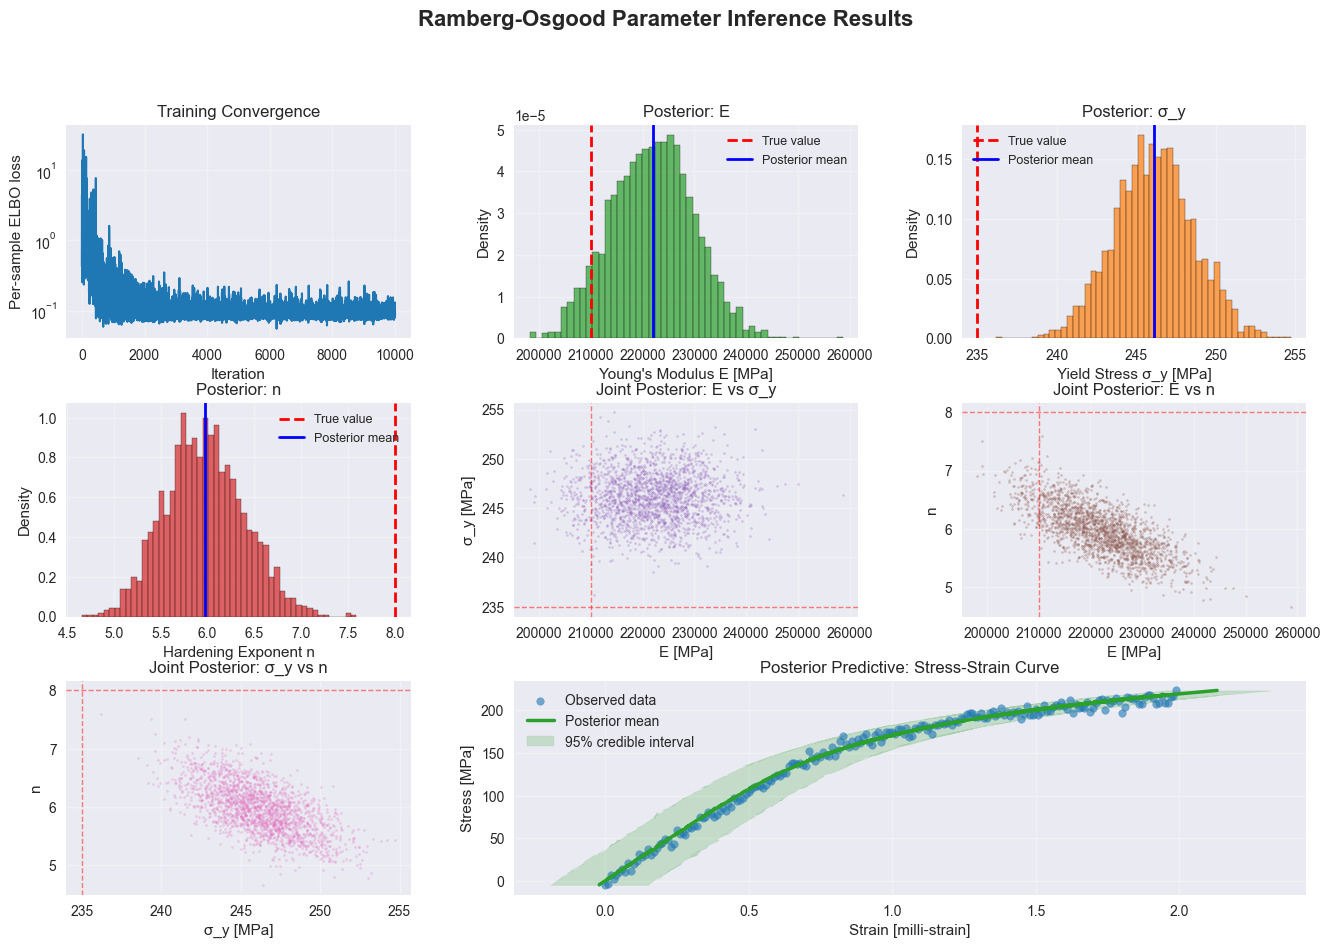

In [9]:
# Posterior analysis and visualization
# Sample from posterior
posterior_ro = Predictive(
    ramberg_osgood_model,
    guide=guide_ro,
    num_samples=2000,
    return_sites=("E", "sigma_y", "n", "obs"),
)(stresses)

# Extract parameter samples
E_samples = posterior_ro["E"].detach().cpu().numpy()
sigma_y_samples = posterior_ro["sigma_y"].detach().cpu().numpy()
n_samples = posterior_ro["n"].detach().cpu().numpy()
strain_samples = posterior_ro["obs"].detach().cpu().numpy()

# Create summary statistics
print("\n" + "="*60)
print("POSTERIOR SUMMARY STATISTICS")
print("="*60)
print("Parameter          | True Value | Posterior Mean | 95% CI")
print("-"*60)
print(f"E (MPa)           | {true_E:10.1f} | {E_samples.mean():14.1f} | [{np.percentile(E_samples, 2.5):.1f}, {np.percentile(E_samples, 97.5):.1f}]")
print(f"σ_y (MPa)         | {true_sigma_y:10.1f} | {sigma_y_samples.mean():14.1f} | [{np.percentile(sigma_y_samples, 2.5):.1f}, {np.percentile(sigma_y_samples, 97.5):.1f}]")
print(f"n (hardening exp) | {true_n:10.1f} | {n_samples.mean():14.2f} | [{np.percentile(n_samples, 2.5):.2f}, {np.percentile(n_samples, 97.5):.2f}]")
print("="*60)

# Compute predictive statistics
mean_strain = strain_samples.mean(axis=0)
lower_strain = np.percentile(strain_samples, 2.5, axis=0)
upper_strain = np.percentile(strain_samples, 97.5, axis=0)


fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Loss curve
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(ro_losses, color="#1f77b4", linewidth=1.5)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Per-sample ELBO loss")
ax1.set_title("Training Convergence")
ax1.set_yscale("log")
ax1.grid(True, alpha=0.3)

# 2-4. Marginal posteriors
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(E_samples, bins=50, density=True, color="#2ca02c", alpha=0.7, edgecolor="black")
ax2.axvline(true_E, color="red", linestyle="--", linewidth=2, label="True value")
ax2.axvline(E_samples.mean(), color="blue", linestyle="-", linewidth=2, label="Posterior mean")
ax2.set_xlabel("Young's Modulus E [MPa]")
ax2.set_ylabel("Density")
ax2.set_title("Posterior: E")
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(sigma_y_samples, bins=50, density=True, color="#ff7f0e", alpha=0.7, edgecolor="black")
ax3.axvline(true_sigma_y, color="red", linestyle="--", linewidth=2, label="True value")
ax3.axvline(sigma_y_samples.mean(), color="blue", linestyle="-", linewidth=2, label="Posterior mean")
ax3.set_xlabel("Yield Stress σ_y [MPa]")
ax3.set_ylabel("Density")
ax3.set_title("Posterior: σ_y")
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(n_samples, bins=50, density=True, color="#d62728", alpha=0.7, edgecolor="black")
ax4.axvline(true_n, color="red", linestyle="--", linewidth=2, label="True value")
ax4.axvline(n_samples.mean(), color="blue", linestyle="-", linewidth=2, label="Posterior mean")
ax4.set_xlabel("Hardening Exponent n")
ax4.set_ylabel("Density")
ax4.set_title("Posterior: n")
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# 5-7. Joint posteriors (2D scatter plots)
ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(E_samples, sigma_y_samples, s=2, alpha=0.3, color="#9467bd")
ax5.axvline(true_E, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax5.axhline(true_sigma_y, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax5.set_xlabel("E [MPa]")
ax5.set_ylabel("σ_y [MPa]")
ax5.set_title("Joint Posterior: E vs σ_y")
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
ax6.scatter(E_samples, n_samples, s=2, alpha=0.3, color="#8c564b")
ax6.axvline(true_E, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax6.axhline(true_n, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax6.set_xlabel("E [MPa]")
ax6.set_ylabel("n")
ax6.set_title("Joint Posterior: E vs n")
ax6.grid(True, alpha=0.3)

ax7 = fig.add_subplot(gs[2, 0])
ax7.scatter(sigma_y_samples, n_samples, s=2, alpha=0.3, color="#e377c2")
ax7.axvline(true_sigma_y, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax7.axhline(true_n, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax7.set_xlabel("σ_y [MPa]")
ax7.set_ylabel("n")
ax7.set_title("Joint Posterior: σ_y vs n")
ax7.grid(True, alpha=0.3)

# 8. Posterior predictive on stress-strain curve
ax8 = fig.add_subplot(gs[2, 1:])
# Plot observed data
ax8.scatter(strains.numpy() * 1e3, stresses.numpy(), 
           s=30, color="#1f77b4", alpha=0.6, label="Observed data", zorder=3)
# Plot posterior mean
ax8.plot(mean_strain * 1e3, stresses.numpy(), 
        color="#2ca02c", linewidth=2.5, label="Posterior mean", zorder=4)
# Plot credible interval
ax8.fill_betweenx(stresses.numpy(), lower_strain * 1e3, upper_strain * 1e3,
                  color="#2ca02c", alpha=0.2, label="95% credible interval", zorder=1)

ax8.set_xlabel("Strain [milli-strain]")
ax8.set_ylabel("Stress [MPa]")
ax8.set_title("Posterior Predictive: Stress-Strain Curve")
ax8.legend(loc="upper left", fontsize=10)
ax8.grid(True, alpha=0.3)

plt.suptitle("Ramberg-Osgood Parameter Inference Results", fontsize=16, fontweight="bold", y=0.995)
plt.show()

We see that while the posterior mean and credible intervals for the stress-strain curve fit the data well, there is still significant uncertainty in the inferred parameters, with the true values lying in some cases outside of the credible intervals. You can experiment with different levels of noise in the observed data, as well as different prior distributions to see how they affect the posterior estimates. Also, if you look closely at the joint distributions of the parameters, you can see that there are correlations between them, indicating that certain combinations of parameters can produce similar stress-strain behavior. This highlights the importance of considering the full posterior distribution rather than just point estimates when inferring material properties.

For completeness, we also demonstrate below how to use Pyro's MCMC functionality, instead of SVI::

In [10]:
#| code-fold: false
# Pyro Example using MCMC Inference:
nuts_kernel = NUTS(ramberg_osgood_model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=300)
mcmc.run(stresses, strains)
mcmc.get_samples()['E'].mean(0)  

Sample: 100%|██████████| 2300/2300 [02:53, 13.24it/s, step size=1.37e-01, acc. prob=0.940]


tensor(219903.2188)

MCMC Estimated E: 219903.22 MPa
MCMC Estimated σ_y: 244.88 MPa
MCMC Estimated n: 6.07

POSTERIOR SUMMARY STATISTICS
Parameter          | True Value | Posterior Mean | 95% CI
------------------------------------------------------------
E (MPa)           |   210000.0 |       219903.2 | [207923.0, 233500.7]
σ_y (MPa)         |      235.0 |          244.9 | [241.8, 248.2]
n (hardening exp) |        8.0 |           6.07 | [5.41, 6.79]


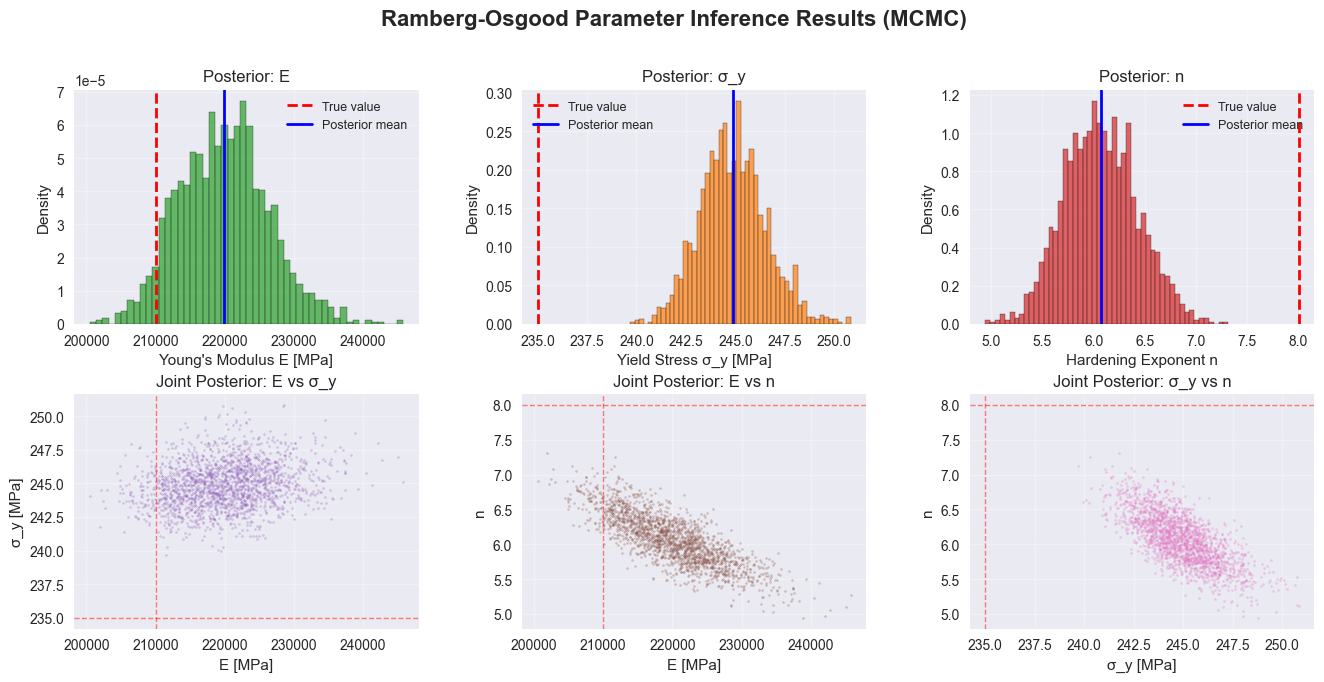

In [12]:
# Extract MCMC samples
mcmc_samples = mcmc.get_samples()
E_mcmc_samples = mcmc_samples['E'].detach().cpu().numpy()
sigma_y_mcmc_samples = mcmc_samples['sigma_y'].detach().cpu().numpy()
n_mcmc_samples = mcmc_samples['n'].detach().cpu().numpy()
print(f"MCMC Estimated E: {E_mcmc_samples.mean():.2f} MPa")
print(f"MCMC Estimated σ_y: {sigma_y_mcmc_samples.mean():.2f} MPa")
print(f"MCMC Estimated n: {n_mcmc_samples.mean():.2f}")

# Create summary statistics
print("\n" + "="*60)
print("POSTERIOR SUMMARY STATISTICS")
print("="*60)
print("Parameter          | True Value | Posterior Mean | 95% CI")
print("-"*60)
print(f"E (MPa)           | {true_E:10.1f} | {E_mcmc_samples.mean():14.1f} | [{np.percentile(E_mcmc_samples, 2.5):.1f}, {np.percentile(E_mcmc_samples, 97.5):.1f}]")
print(f"σ_y (MPa)         | {true_sigma_y:10.1f} | {sigma_y_mcmc_samples.mean():14.1f} | [{np.percentile(sigma_y_mcmc_samples, 2.5):.1f}, {np.percentile(sigma_y_mcmc_samples, 97.5):.1f}]")
print(f"n (hardening exp) | {true_n:10.1f} | {n_mcmc_samples.mean():14.2f} | [{np.percentile(n_mcmc_samples, 2.5):.2f}, {np.percentile(n_mcmc_samples, 97.5):.2f}]")
print("="*60)

fig = plt.figure(figsize=(16, 7))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 2-4. Marginal posteriors
ax2 = fig.add_subplot(gs[0, 0])
ax2.hist(E_mcmc_samples, bins=50, density=True, color="#2ca02c", alpha=0.7, edgecolor="black")
ax2.axvline(true_E, color="red", linestyle="--", linewidth=2, label="True value")
ax2.axvline(E_mcmc_samples.mean(), color="blue", linestyle="-", linewidth=2, label="Posterior mean")
ax2.set_xlabel("Young's Modulus E [MPa]")
ax2.set_ylabel("Density")
ax2.set_title("Posterior: E")
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 1])
ax3.hist(sigma_y_mcmc_samples, bins=50, density=True, color="#ff7f0e", alpha=0.7, edgecolor="black")
ax3.axvline(true_sigma_y, color="red", linestyle="--", linewidth=2, label="True value")
ax3.axvline(sigma_y_mcmc_samples.mean(), color="blue", linestyle="-", linewidth=2, label="Posterior mean")
ax3.set_xlabel("Yield Stress σ_y [MPa]")
ax3.set_ylabel("Density")
ax3.set_title("Posterior: σ_y")
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[0, 2])
ax4.hist(n_mcmc_samples, bins=50, density=True, color="#d62728", alpha=0.7, edgecolor="black")
ax4.axvline(true_n, color="red", linestyle="--", linewidth=2, label="True value")
ax4.axvline(n_mcmc_samples.mean(), color="blue", linestyle="-", linewidth=2, label="Posterior mean")
ax4.set_xlabel("Hardening Exponent n")
ax4.set_ylabel("Density")
ax4.set_title("Posterior: n")
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# 5-7. Joint posteriors (2D scatter plots)
ax5 = fig.add_subplot(gs[1, 0])
ax5.scatter(E_mcmc_samples, sigma_y_mcmc_samples, s=2, alpha=0.3, color="#9467bd")
ax5.axvline(true_E, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax5.axhline(true_sigma_y, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax5.set_xlabel("E [MPa]")
ax5.set_ylabel("σ_y [MPa]")
ax5.set_title("Joint Posterior: E vs σ_y")
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 1])
ax6.scatter(E_mcmc_samples, n_mcmc_samples, s=2, alpha=0.3, color="#8c564b")
ax6.axvline(true_E, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax6.axhline(true_n, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax6.set_xlabel("E [MPa]")
ax6.set_ylabel("n")
ax6.set_title("Joint Posterior: E vs n")
ax6.grid(True, alpha=0.3)

ax7 = fig.add_subplot(gs[1, 2])
ax7.scatter(sigma_y_mcmc_samples, n_mcmc_samples, s=2, alpha=0.3, color="#e377c2")
ax7.axvline(true_sigma_y, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax7.axhline(true_n, color="red", linestyle="--", linewidth=1, alpha=0.5)
ax7.set_xlabel("σ_y [MPa]")
ax7.set_ylabel("n")
ax7.set_title("Joint Posterior: σ_y vs n")
ax7.grid(True, alpha=0.3)

plt.suptitle("Ramberg-Osgood Parameter Inference Results (MCMC)", fontsize=16, fontweight="bold", y=0.995)
plt.show()

## Summary and Next Steps

This chapter introduced the concept of Probabilistic Programming Languages (PPLs) and demonstrated their application in inferring material properties from stress-strain data using Pyro. We started with a simple Bayesian linear regression example to illustrate the basic workflow of defining a model, guide, and performing inference using Stochastic Variational Inference (SVI). We then extended this to a more complex Ramberg-Osgood material model, showcasing how PPLs can simplify the implementation of probabilistic models and inference for more intricate scenarios. While there wasn't much new in this chapter that we didn't already know how to do from prior chapters, the key takeaway is that PPLs in general can significantly streamline the process of defining and inferring complex probabilistic models, making them more accessible for practical applications in engineering.